<a href="https://colab.research.google.com/github/ZzangJay/team_project/blob/kimjisan/20221105_code_js.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
#import tensorflow as tf 
import os
import sys
from datetime import datetime, timedelta
from tqdm.autonotebook import tqdm
import csv
import re
import gzip
import shutil

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


In [2]:
from google.colab import drive  # for colab
drive.mount('/content/gdrive/')  # for colab
cloud_directory = '/content/gdrive/MyDrive/mimiciv_unzip/'
os.listdir(cloud_directory) # for colab, check cloud directory mount

Mounted at /content/gdrive/


['CHANGELOG.txt',
 'LICENSE.txt',
 'SHA256SUMS.txt',
 'index.html',
 'icu',
 'hosp',
 'drop_2_chartevents.csv']

In [3]:
admission = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/admissions.csv', low_memory=False, dtype='str', keep_default_na=False)
patients = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/patients.csv', low_memory=False, dtype='str', keep_default_na=False)
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/hosp/diagnoses_icd.csv', low_memory=False, dtype='str', keep_default_na=False)
icustays = pd.read_csv('/content/gdrive/MyDrive/mimiciv_unzip/icu/icustays.csv', low_memory=False, dtype='str', keep_default_na=False)
sepsis = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/sepsis3.csv', low_memory=False, dtype='str', keep_default_na=False)

In [4]:
admission = pd.merge(left = admission, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
patients = pd.merge(left = patients, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')
sepsis = pd.merge(left = sepsis, right = icustays[['hadm_id','stay_id']], how='left', left_on='stay_id', right_on='stay_id')

In [5]:
Total_HADMIDS = set(sepsis['hadm_id'])

In [6]:
feature_keys = ['FiO2', 'HR', 'PaO2', 'SBP', 'Temperature','Creatinine','Glucose', 'Hb', 'Lactate', 'Plt','Sodium' ,'WBC']

In [7]:
EXTRACT_FEATURE_CODES_VS = dict({
    '226754': 'FiO2', '223835': 'FiO2', '227010': 'FiO2', '229280':'FiO2', '229841': 'FiO2',
    '220045': 'HR', '220046': 'HR', '226764': 'HR', '227018': 'HR',
    '220224': 'PaO2', '227039': 'PaO2', '227516': 'PaO2',
    '220050': 'SBP' ,'220179': 'SBP', '224167': 'SBP', '227243': 'SBP', '228152': 'SBP',
    '223762': 'Temperature', '226329': 'Temperature', '227632': 'Temperature', '227634': 'Temperature',
    })
EXTRACT_FEATURE_CODES_LAB = dict({
    '220615': 'Creatinine', '229761': 'Creatinine',
    '220621': 'Glucose', '225664': 'Glucose', '226537': 'Glucose',
    '220228': 'Hb',
    '225668': 'Lactate',
    '227457': 'Plt',
    '220645': 'Sodium', '226534': 'Sodium',
    '220546': 'WBC'}) 
EXTRACT_FEATURE_CODES_NORMAL = dict({
        'FiO2': [10, 100],
        'HR': [30, 200],
        'PaO2': [50, 200],
        'SBP': [40, 250],
        'Temperature': [30, 45],
        'Creatinine': [0.2, 100],
        'Glucose': [30, 1000],
        'Hb': [5, 20],
        'Lactate': [0.5, 2.5],
        'Plt': [10, 500],
        'Sodium': [90, 170],
        'WBC': [1, 30]
})
NORMAL_VALUE = dict({
        'FiO2': 40,
        'HR': 75, #(50+100)/2
        'PaO2': 87.5, #(75+100)/2
        'SBP': 115, #(90+140)/2 = 115
        'Temperature': 36.65, #(36.1+37.2)/2
        'Creatinine': 1.0, #(0.7+1.0)/2
        'Glucose': 100, #(60+140)/2
        'Hb': 15.0, #(13.8+17.2)/2
        'Lactate': 1.35, #(0.5+2.2)/2 = 1.35
        'Plt': 270, #(140+400)/2
        'Sodium': 140, #(135+145)/2
        'WBC': 7.5 #(5+10)/2
})

# EXTRACT_FEATURE_CODES_anti = ('225798','225837','225838','225840','225842','225843','225844','225845','225847','225848','225850','225851','225853','225855','225857','225859','225860','225862','225863','225865','225866','225868','225869','225871','225873','225875','225876','225877','225879','225881','225882','225883','225884','225885','225886','225888','225889','225890','225892','225893','225895','225896','225897','225898','225899','225900','225902','225903','225905','227691','228003','229059','229061','229064','229587')
# EXTRACT_FEATURE_CODES_ANTI_2 = dict({
#    '225850': 'Cephalosporin', '225851': 'Cephalosporin', '225853': 'Cephalosporin', '225855': 'Cephalosporin', '229587':'Cephalosporin',
#    '225798': 'Glycopetide',
#    '225842': 'Penicillin', '225843': 'Penicillin', '225888': 'Penicillin', '225889': 'Penicillin', '225890': 'Penicillin', '225892': 'Penicillin', '225893': 'Penicillin',
#    '225859': 'Quninolone', '225859': 'Quninolone', '225879': 'Quninolone', '225886': 'Quninolone',
#    '225845': 'Macrolide', '225865': 'Macrolide', '225866': 'Macrolide'
# })

In [8]:
## Define some util functions
NOT_CONVERTED = 'NOT_CONVERTED'
## 문자로 기록된 날짜 값들을 파이썬의 datetime 데이터로 바꿔주는 함수 작성
def str2datetime(s):
    def _convert(_s, _dformat):
        try:
            converted_dt = datetime.strptime(_s, _dformat)
        except Exception:
            return NOT_CONVERTED

        return converted_dt

    if isinstance(s, datetime):
        return s

    dformats = [
        '%Y-%m-%d %p %I:%M:%S',
        '%Y-%m-%d %H:%M:%S.%f',
        '%Y-%m-%d %H:%M:%S',
        '%Y-%m-%d %H:%M',
        '%y-%m-%d %H:%M',
        '%Y-%m-%d',
        '%Y%m%d',
        '%Y-%m-%d +%H:%M',
        '%Y%m%d %H%M',
        '%Y%m%d%H%M%S',
        ]

    s = s.split('.')[0]
    s = s.replace('오전', 'am').replace('오후', 'pm')
    for dformat in dformats:
        dt = _convert(s, dformat)
        if dt != NOT_CONVERTED:
            return dt

    return NOT_CONVERTED

In [9]:
def extract_features():
  features_hadm_id = dict()
  chartevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/icu/chartevents.csv', 'r', encoding='utf-8'))
  labevents = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_unzip/hosp/labevents.csv', 'r', encoding='utf-8'))
  for row in tqdm(chartevents, desc='Extract_VS', total=329822285, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict()) #get 없으면 2번째로 return

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_VS:
        continue
      item_name = EXTRACT_FEATURE_CODES_VS[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue
      #GCP total score도 시간대에 총합으로 사용함
      if item_name == 'TEMP_F':
        item_value = round((item_value - 32.0) / 1.8, 2)
        item_name = 'TEMP'

    #   if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][1]
    #   elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
    #     item_value = FEATURE_NORMAL_RANGE[item_name][0]

      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list()) #같은 환자의 여러개 feature가 있으면 list로 반환하도록
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue

  for row in tqdm(labevents, desc='Extract_LAB', total=124342638, ncols=700):
    if row['hadm_id'] in Total_HADMIDS:
      hadm_id = row['hadm_id']
      features_hadm_id[hadm_id] = features_hadm_id.get(hadm_id, dict())

      item_id = row['itemid']
      if item_id not in EXTRACT_FEATURE_CODES_LAB:
        continue
      item_name = EXTRACT_FEATURE_CODES_LAB[item_id]
      try:
        #정규식을 이용해서 기록된 값에서 숫자 형태의 값만 가져오기
        #소수점 둘째자리 까지만 값을 사용하기
        item_value = round(float(re.findall("\d+\.\d+|\d+", row['valuenum'])[0]), 2)
      except Exception:
        continue
      
      item_time = str2datetime(row['charttime'])
      if item_time == NOT_CONVERTED:
        continue

      #if item_value > FEATURE_NORMAL_RANGE[item_name][1]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][1]
      #elif item_value < FEATURE_NORMAL_RANGE[item_name][0]:
      #  item_value = FEATURE_NORMAL_RANGE[item_name][0]
        
      features_hadm_id[hadm_id][item_name] = features_hadm_id[hadm_id].get(item_name, list())
      features_hadm_id[hadm_id][item_name].append((item_time, item_value))
      
    else:
      continue
      
  return features_hadm_id

In [10]:
# extracted_features = extract_features()

In [11]:
import pickle
import gzip

In [12]:
# with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features.pickle', 'wb') as f:
#     pickle.dump(extracted_features, f)

In [13]:
with gzip.open('/content/gdrive/MyDrive/sepsis_model_weight/extracted_features.pickle','rb') as f:
    extracted_features = pickle.load(f)

In [14]:
# 사망 레이블 하기
death_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get Death Label'):
  hadm_id = row['hadm_id']
  death_yn = int(row['hospital_expire_flag'])
  if death_yn:
    event_time = str2datetime(row['deathtime'])
  else:
    event_time = str2datetime(row['dischtime'])
  death_labels[hadm_id] = dict({'DEATH': death_yn, 'EVENT_TIME': event_time})

Get Death Label: 0it [00:00, ?it/s]

In [15]:
# 재실 기간 레이블 하기
los_labels = dict()
admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in tqdm(admissions, desc='Get loss Label'):
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])
  los = (disc_time - admin_time).total_seconds() / (60*60)
  los_labels[hadm_id] = int(los)

Get loss Label: 0it [00:00, ?it/s]

In [16]:
## 환자의 입실 퇴실 시간 정보 가져오기
Extracted_HADMIDS = list(extracted_features.keys())
admin_disc_time = dict()

admissions = csv.DictReader(open('/content/gdrive/MyDrive/mimiciv_der/sepsis3_admissions.csv', 'r', encoding='utf-8'))
for row in admissions:
  hadm_id = row['hadm_id']
  admin_time = str2datetime(row['admittime'])
  disc_time = str2datetime(row['dischtime'])

  if (admin_time != NOT_CONVERTED) and (disc_time != NOT_CONVERTED):
    admin_disc_time[hadm_id] = dict({'ADMIN': admin_time, 'DISC': disc_time})

In [17]:
## 입실 시점으로부터 1시간 간격으로 데이터를 읽어오는 함수 정의
def quantize_features(feature_list, admin_time, disc_time, missing_feature=False):
  total_hours = int((disc_time - admin_time).total_seconds() / (60*60))
  #입실 이후 최대 24시간 동안의 데이터만 가져오기
  if total_hours > 24:
    total_hours = 24
  
  quantized_features = list()
  if missing_feature:
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_value = np.nan #지금은 dic 형태라, pandas 쓰면 NAN이랑 동일, carry forward 도 가능
      quantized_features.append((quantized_time, quantized_value))
  else:
    feature_list = list(sorted(feature_list, key=lambda x: x[0]))
    for i in range(total_hours):
      quantized_time = admin_time + timedelta(hours=i)
      quantized_time_start = quantized_time - timedelta(hours=1)
      quantized_values = list(filter(lambda x: quantized_time_start < x[0] <= quantized_time, feature_list)) #filter함수 True만 필터
      if len(quantized_values) > 0:
        quantized_value = quantized_values[-1][1]
      else:
        quantized_value = np.nan 

      quantized_features.append((quantized_time, quantized_value))
  
  return quantized_features

In [18]:
## 전체 데이터에 대해서 데이터 변환하기
quantized_features = dict()
for hadm_id in tqdm(Extracted_HADMIDS, desc='Doing Quantization'):
    admin_time = admin_disc_time[hadm_id]['ADMIN']
    disc_time = admin_disc_time[hadm_id]['DISC']
    if (disc_time - admin_time).total_seconds() / (60*60) < 1.0:
      continue
    quantized_features[hadm_id] = dict()
    for kk in feature_keys:
      if kk in extracted_features[hadm_id]:
        feature_list = extracted_features[hadm_id][kk]
        quantized_features[hadm_id][kk] = quantize_features(feature_list, admin_time, disc_time)
      else:
        quantized_features[hadm_id][kk] = quantize_features(None, admin_time, disc_time, missing_feature=True)


Doing Quantization:   0%|          | 0/32812 [00:00<?, ?it/s]

In [19]:
def carry_forward(feature_name, feature_list):
  imputed_features = list()
  for i, (feature_t, feature_v) in enumerate(feature_list):
    if np.isnan(feature_v):
      last_observations = list(filter(lambda x: (x[0] <= feature_t) and (not np.isnan(x[1])), feature_list))
      if len(last_observations) > 0:
        imputed_features.append((feature_t, last_observations[-1][1]))
      else:
        imputed_features.append((feature_t, NORMAL_VALUE[feature_name]))
    else:
      imputed_features.append((feature_t, feature_v))

  return imputed_features

In [20]:
Quantized_HADMIDS = list(quantized_features.keys())
carry_forwarded_features = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Carry-Forward'):
  carry_forwarded_features[hadm_id] = dict()

  for kk in feature_keys:
    feature_list = quantized_features[hadm_id][kk]
    carry_forwarded_features[hadm_id][kk] = carry_forward(kk, feature_list)

Carry-Forward:   0%|          | 0/32785 [00:00<?, ?it/s]

In [21]:
#Min-Max Normalization
min_max_normalized = dict()
for hadm_id in tqdm(Quantized_HADMIDS, desc='Min-Max Normalization', ncols=700):
  min_max_normalized[hadm_id] = dict()
  for kk in feature_keys:
    features = np.array(carry_forwarded_features[hadm_id][kk])

    min = EXTRACT_FEATURE_CODES_NORMAL[kk][0]
    max = EXTRACT_FEATURE_CODES_NORMAL[kk][1]

    features[:, 1] = (features[:, 1] - min) / (max - min)
    min_max_normalized[hadm_id][kk] = features

Min-Max Normalization:   0%|                                                                                  …

In [22]:
total_death_included_hadm_ids = list(death_labels.keys())
total_los_included_hadm_ids = list(los_labels.keys())

In [23]:
## 사망 예측용 데이터
death_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_death_included_hadm_ids, desc='Make Death Dataset', ncols=700):
  if hadm_id not in min_max_normalized:
    continue
  if len(min_max_normalized[hadm_id][feature_keys[0]]) >= 24:
    time_len = 24
  else:
    time_len = len(min_max_normalized[hadm_id][feature_keys[0]])
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  death_dataset['HADM_IDS'].append(hadm_id)
  death_dataset['LABEL'].append(death_labels[hadm_id]['DEATH'])
  death_dataset['DATA'].append(data)

Make Death Dataset:   0%|                                                                                     …

In [24]:
id_cepha = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_cepha.csv', low_memory=False, dtype='str', keep_default_na=False)
id_glyco = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_glyco.csv', low_memory=False, dtype='str', keep_default_na=False)
id_peni = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_peni.csv', low_memory=False, dtype='str', keep_default_na=False)
id_fluoro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_fluoro.csv', low_memory=False, dtype='str', keep_default_na=False)
id_macro = pd.read_csv('/content/gdrive/MyDrive/mimiciv_der/temp/id_macro.csv', low_memory=False, dtype='str', keep_default_na=False)

In [25]:
len(death_dataset['HADM_IDS'])

32785

In [26]:
cepha_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

glyco_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

peni_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

fluoro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

macro_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

In [27]:
list_glyco=[]
for i in id_glyco['hadm_id']:
  list_glyco.append(i)

list_cepha=[]
for i in id_cepha['hadm_id']:
  list_cepha.append(i)

list_peni=[]
for i in id_peni['hadm_id']:
  list_peni.append(i)

list_fluoro=[]
for i in id_fluoro['hadm_id']:
  list_fluoro.append(i)

list_macro=[]
for i in id_macro['hadm_id']:
  list_macro.append(i)


In [28]:
for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Glycopeptides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_glyco) == True:
      glyco_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      glyco_dataset['LABEL'].append(death_dataset['LABEL'][i])
      glyco_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Cephalosporins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_cepha) == True:
      cepha_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      cepha_dataset['LABEL'].append(death_dataset['LABEL'][i])
      cepha_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Penicillins Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_peni) == True:
      peni_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      peni_dataset['LABEL'].append(death_dataset['LABEL'][i])
      peni_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Fluoroquinolones Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_fluoro) == True:
      fluoro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      fluoro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      fluoro_dataset['DATA'].append(death_dataset['DATA'][i])

for i in tqdm(range(len(death_dataset['HADM_IDS'])), desc='Make Macrolides Dataset', ncols = 700):
  if (death_dataset['HADM_IDS'][i] in list_macro) == True:
      macro_dataset['HADM_IDS'].append(death_dataset['HADM_IDS'][i])
      macro_dataset['LABEL'].append(death_dataset['LABEL'][i])
      macro_dataset['DATA'].append(death_dataset['DATA'][i])

print(len(glyco_dataset['HADM_IDS']))
print(len(cepha_dataset['HADM_IDS']))
print(len(peni_dataset['HADM_IDS']))
print(len(fluoro_dataset['HADM_IDS']))
print(len(macro_dataset['HADM_IDS']))

Make Glycopeptides Dataset:   0%|                                                                             …

Make Cephalosporins Dataset:   0%|                                                                            …

Make Penicillins Dataset:   0%|                                                                               …

Make Fluoroquinolones Dataset:   0%|                                                                          …

Make Macrolides Dataset:   0%|                                                                                …

11754
10954
6062
3653
1919


In [29]:
## 재실기간 예측용 데이터
los_dataset = dict({
    'HADM_IDS': list(),
    'LABEL': list(),
    'DATA': list()
})

for hadm_id in tqdm(total_los_included_hadm_ids, desc='Make LOS Dataset', ncols=700):
  time_len = 12
  
  try:
    data = np.array(min_max_normalized[hadm_id][feature_keys[0]])[:time_len, 1].reshape(time_len, 1)
  except:
    continue

  for kk in feature_keys[1:]:
    data = np.concatenate((data, np.array(min_max_normalized[hadm_id][kk])[:time_len, 1].reshape(time_len, 1)), axis=1)
  
  los_dataset['HADM_IDS'].append(hadm_id)
  los_dataset['LABEL'].append(los_labels[hadm_id])
  los_dataset['DATA'].append(data)

Make LOS Dataset:   0%|                                                                                       …

## train-test 분할

In [30]:
## 학습용 검증용 데이터 나누기 (8:2)
def split_train_test(dataset, train_ratio=0.8, pos_neg=True):
  #레이블이 양성, 음성인 경우, 학습 데이터, 테스트 데이터를 나눌 때 
  #양성, 음성의 비율을 각각 유지할 수 있도록 구현
  if pos_neg:
    pos_idx = np.where(np.array(dataset['LABEL']) == 1)[0]
    neg_idx = np.where(np.array(dataset['LABEL']) == 0)[0]

    # suffle 넣어줘서 index 섞어줘야함. np.random, random,suffle
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)

    pos_num = len(pos_idx)
    neg_num = len(neg_idx)

    train_pos_idx = list(pos_idx[:int(pos_num * train_ratio)])
    test_pos_idx = list(pos_idx[int(pos_num * train_ratio):])

    train_neg_idx = list(neg_idx[:int(neg_num * train_ratio)])
    test_neg_idx = list(neg_idx[int(neg_num * train_ratio):])

    train_idx = train_pos_idx + train_neg_idx
    test_idx = test_pos_idx + test_neg_idx
  
  #레이블이 양성, 음성이 아닌경우 단순하게 전체 데이터에서 학습, 테스트 비율만큼 나누기
  else:
    idx = np.arange(len(dataset['LABEL']))
    np.random.shuffle(idx)
    train_idx = idx[:int(len(idx) * train_ratio)]
    test_idx = idx[int(len(idx) * train_ratio):]

  train_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[train_idx],
      'LABEL': np.array(dataset['LABEL'])[train_idx],
      'DATA': np.array(dataset['DATA'])[train_idx]
  })

  test_set = dict({
      'HADM_IDS': np.array(dataset['HADM_IDS'])[test_idx],
      'LABEL': np.array(dataset['LABEL'])[test_idx],
      'DATA': np.array(dataset['DATA'])[test_idx]
  })
  return train_set, test_set

In [31]:
death_train, death_test = split_train_test(death_dataset)
los_train, los_test = split_train_test(los_dataset, pos_neg=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [32]:
print(len(death_train['HADM_IDS']))
print(len(death_test['HADM_IDS']))
print(len(los_train['HADM_IDS']))
print(len(los_test['HADM_IDS']))

26227
6558
26072
6519


In [33]:
cepha_train, cepha_test = split_train_test(cepha_dataset)
glyco_train, glyco_test = split_train_test(glyco_dataset)
peni_train, peni_test = split_train_test(peni_dataset)
fluoro_train, fluoro_test = split_train_test(fluoro_dataset)
macro_train, macro_test = split_train_test(macro_dataset)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [34]:
print(len(glyco_train['HADM_IDS']))
print(len(glyco_test['HADM_IDS']))
print(len(cepha_train['HADM_IDS']))
print(len(cepha_test['HADM_IDS']))
print(len(peni_train['HADM_IDS']))
print(len(peni_test['HADM_IDS']))
print(len(fluoro_train['HADM_IDS']))
print(len(fluoro_test['HADM_IDS']))
print(len(macro_train['HADM_IDS']))
print(len(macro_test['HADM_IDS']))

9402
2352
8762
2192
4849
1213
2922
731
1534
385


## 모델 학습 


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tensorflow.keras.utils import Sequence
import numpy as np

In [36]:
## 사망예측 모델용 데이터 로더
class Death_Dataloader(Sequence):
    def __init__(self, x_set, y_set, hadm_id_set, batch_size, shuffle=False):
        self.x, self.y, self.hadm_id = x_set, y_set, hadm_id_set
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

		# batch 단위로 직접 묶어줘야 함
    def __getitem__(self, idx):
		# sampler의 역할(index를 batch_size만큼 sampling해줌)
        indices = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        ## 입력 데이터들의 크기를 최대 24시간으로 통일하고 24시간 보다 짧은 데이터들의 경우 끝에 '0' padding 붙이기
        padded_batch_x = np.zeros((len(batch_x), 24, len(feature_keys)))
        for i in range(len(batch_x)):
          valid_length = len(batch_x[i])
          padded_batch_x[i][:valid_length, :] = batch_x[i]
        batch_y = [self.y[i] for i in indices]
        batch_hadm_id = [self.hadm_id[i] for i in indices]

        return np.array(padded_batch_x).astype('float32'), np.array(batch_y).astype('float32')

    # epoch이 끝날때마다 실행
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

# batch 2의 64,128
# resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
# resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [37]:
#항생제 별로 trainloader 만들기
death_train_loader = Death_Dataloader(death_train['DATA'], death_train['LABEL'], death_train['HADM_IDS'], 125, True)
death_test_loader = Death_Dataloader(death_test['DATA'], death_test['LABEL'], death_test['HADM_IDS'], 125, False)

In [38]:
glyco_train_loader = Death_Dataloader(glyco_train['DATA'], glyco_train['LABEL'], glyco_train['HADM_IDS'], 125, True)
glyco_test_loader = Death_Dataloader(glyco_test['DATA'], glyco_test['LABEL'], glyco_test['HADM_IDS'], 125, False)

cepha_train_loader = Death_Dataloader(cepha_train['DATA'], cepha_train['LABEL'], cepha_train['HADM_IDS'], 125, True)
cepha_test_loader = Death_Dataloader(cepha_test['DATA'], cepha_test['LABEL'], cepha_test['HADM_IDS'], 125, False)

peni_train_loader = Death_Dataloader(peni_train['DATA'], peni_train['LABEL'], peni_train['HADM_IDS'], 125, True)
peni_test_loader = Death_Dataloader(peni_test['DATA'], peni_test['LABEL'], peni_test['HADM_IDS'], 125, False)

fluoro_train_loader = Death_Dataloader(fluoro_train['DATA'], fluoro_train['LABEL'], fluoro_train['HADM_IDS'], 125, True)
fluoro_test_loader = Death_Dataloader(fluoro_test['DATA'], fluoro_test['LABEL'], fluoro_test['HADM_IDS'], 125, False)

macro_train_loader = Death_Dataloader(macro_train['DATA'], macro_train['LABEL'], macro_train['HADM_IDS'], 125, True)
macro_test_loader = Death_Dataloader(macro_test['DATA'], macro_test['LABEL'], macro_test['HADM_IDS'], 125, False)

In [39]:
print(1-(sum(glyco_train['LABEL'])/len(glyco_train['LABEL']))) 
print(1-(sum(cepha_train['LABEL'])/len(cepha_train['LABEL'])))
print(1-(sum(peni_train['LABEL'])/len(peni_train['LABEL'])))
print(1-(sum(fluoro_train['LABEL'])/len(fluoro_train['LABEL'])))
print(1-(sum(macro_train['LABEL'])/len(macro_train['LABEL'])))
#print(len(glyco_train['HADM_IDS']))
#print(len(glyco_test['HADM_IDS']))
#print(len(cepha_train['HADM_IDS']))
#print(len(cepha_test['HADM_IDS']))
#print(len(peni_train['HADM_IDS']))
#print(len(peni_test['HADM_IDS']))
#print(len(fluoro_train['HADM_IDS']))
#print(len(fluoro_test['HADM_IDS']))
#print(len(macro_train['HADM_IDS']))
#print(len(macro_test['HADM_IDS']))

0.7841948521591151
0.8519744350604885
0.7937719117343782
0.8497604380561259
0.8409387222946545


In [40]:
## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125, activation='relu'),
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

In [41]:
## 사망예측 모델
#death_lstm = keras.Sequential([
#    layers.LSTM(25, input_shape=(13,16)),
#    layers.Dense(125),
#    layers.BatchNormalization(),
#    layers.Activation('relu'),
#    layers.Dropout(0.2),
#    #batch normalization, dropout,optimizer deat
#    layers.Dense(1, activation='sigmoid')
#])
#death_lstm.summary()

In [57]:
def lstm_model():
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
  model = keras.Sequential([
    layers.LSTM(128, input_shape=(13,16), return_sequences=True),
    layers.LSTM(128),
    layers.Dense(128),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.2),
    #batch normalization, dropout,optimizer deat
    layers.Dense(1, activation='sigmoid')])
  model.summary()

  return model

In [208]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding,Bidirectional,Activation,GRU,BatchNormalization,Dropout,LeakyReLU,ReLU

In [180]:
def lstm_bidirect():
  model = Sequential()
  model.add(Bidirectional(LSTM(25, return_sequences=True),
                             input_shape=(13, 16)))
  model.add(BatchNormalization())
  model.add(Bidirectional(LSTM(25)))
  model.add(BatchNormalization())
  model.add(Dense(128))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['AUC'])

  return model

In [181]:
death_lstm=lstm_bidirect()

In [ ]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/lstm_model.{epoch:02d}-{val_auc:.3f}.h5',save_best_only=True)]
history_lstm = death_lstm.fit(death_train_loader,validation_data=death_test_loader,
                    batch_size=32, epochs=200,callbacks=callback)

In [317]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.02,
    decay_steps=100000,
    decay_rate=0.96)
optimizer_decay = keras.optimizers.SGD(learning_rate=lr_schedule)

In [318]:
def gru_bidirect():
  model = Sequential()
  model.add(Bidirectional(GRU(32, return_sequences=True),
                             input_shape=(13, 16)))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Bidirectional(GRU(16)))
  model.add(BatchNormalization())
  model.add(Dropout(0.1))
  model.add(Dense(128))
  model.add(BatchNormalization())
  model.add(LeakyReLU())
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer=optimizer_decay, metrics=['AUC'])
  
  model.summary()

  return model

In [319]:
death_gru=gru_bidirect()

Model: "sequential_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_145 (Bidirect  (None, 13, 64)           9600      
 ional)                                                          
                                                                 
 batch_normalization_151 (Ba  (None, 13, 64)           256       
 tchNormalization)                                               
                                                                 
 dropout_85 (Dropout)        (None, 13, 64)            0         
                                                                 
 bidirectional_146 (Bidirect  (None, 32)               7872      
 ional)                                                          
                                                                 
 batch_normalization_152 (Ba  (None, 32)               128       
 tchNormalization)                                   

In [320]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=50),
            tf.keras.callbacks.ModelCheckpoint(filepath='/content/gdrive/MyDrive/sepsis_model_weight/gru_model/gru_model.{epoch:02d}-{val_auc:.3f}.h5',save_best_only=True)]
history = death_gru.fit(death_train_loader,validation_data=death_test_loader,
                    batch_size=32, epochs=1000,callbacks=callback)

Epoch 1/1000
210/210 [==============================] - 10s 20ms/step - loss: 0.4496 - auc: 0.5934 - val_loss: 0.5404 - val_auc: 0.5632
Epoch 2/1000
210/210 [==============================] - 3s 13ms/step - loss: 0.4107 - auc: 0.6365 - val_loss: 0.5449 - val_auc: 0.5959
Epoch 3/1000
210/210 [==============================] - 3s 13ms/step - loss: 0.4049 - auc: 0.6485 - val_loss: 0.4156 - val_auc: 0.6198
Epoch 4/1000
210/210 [==============================] - 3s 13ms/step - loss: 0.4046 - auc: 0.6477 - val_loss: 0.4065 - val_auc: 0.6347
Epoch 5/1000
210/210 [==============================] - 3s 14ms/step - loss: 0.4012 - auc: 0.6605 - val_loss: 0.4069 - val_auc: 0.6434
Epoch 6/1000
210/210 [==============================] - 3s 13ms/step - loss: 0.4007 - auc: 0.6600 - val_loss: 0.4082 - val_auc: 0.6454
Epoch 7/1000
210/210 [==============================] - 3s 14ms/step - loss: 0.4002 - auc: 0.6619 - val_loss: 0.4037 - val_auc: 0.6536
Epoch 8/1000
210/210 [==============================] 

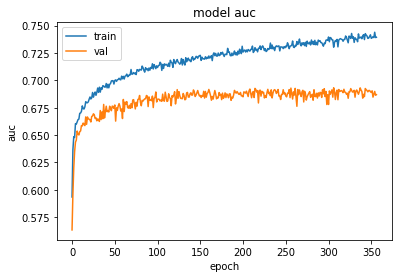

In [321]:
from matplotlib import pyplot as plt
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [49]:
# Trainset, Testset에 대한 ROC 커브 그리고 Confusion Matrix 구해보기
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, average_precision_score, confusion_matrix

%matplotlib inline
lstm_train_predicts, lstm_test_predicts = list(), list()
lstm_train_labels, lstm_test_labels = list(), list()

for tr_x, tr_y in death_train_loader:
  batch_predict = death_lstm.predict(tr_x)
  lstm_train_predicts.append(batch_predict)
  lstm_train_labels.append(tr_y)

  batch_predict = death_trans.predict(tr_x)
  trans_train_predicts.append(batch_predict)
  trans_train_labels.append(tr_y)

for test_x, test_y in death_test_loader:
  batch_predict = death_lstm.predict(test_x)
  lstm_test_predicts.append(batch_predict)
  lstm_test_labels.append(test_y)

  batch_predict = death_trans.predict(test_x)
  trans_test_predicts.append(batch_predict)
  trans_test_labels.append(test_y)

lstm_train_predicts = np.concatenate(lstm_train_predicts).reshape(-1, 1)
lstm_train_labels = np.concatenate(lstm_train_labels).astype('int')
lstm_test_predicts = np.concatenate(lstm_test_predicts).reshape(-1, 1)
lstm_test_labels = np.concatenate(lstm_test_labels).astype('int')

trans_train_predicts = np.concatenate(trans_train_predicts).reshape(-1, 1)
trans_train_labels = np.concatenate(trans_train_labels).astype('int')
trans_test_predicts = np.concatenate(trans_test_predicts).reshape(-1, 1)
trans_test_labels = np.concatenate(trans_test_labels).astype('int')


trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)
# trans_train_roc_x, trans_train_roc_y, _ = roc_curve(trans_train_labels, trans_train_predicts)
# trans_train_auroc = roc_auc_score(trans_train_labels, trans_train_predicts)
# trans_test_roc_x, trans_test_roc_y, _ = roc_curve(trans_test_labels, trans_test_predicts)
# trans_test_auroc = roc_auc_score(trans_test_labels, trans_test_predicts)

lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)
# lstm_train_roc_x, lstm_train_roc_y, _ = roc_curve(lstm_train_labels, lstm_train_predicts)
# lstm_train_auroc = roc_auc_score(lstm_train_labels, lstm_train_predicts)
# lstm_test_roc_x, lstm_test_roc_y, _ = roc_curve(lstm_test_labels, lstm_test_predicts)
# lstm_test_auroc = roc_auc_score(lstm_test_labels, lstm_test_predicts)

plt.figure()
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve')


plt.plot(lstm_train_roc_x, lstm_train_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Train', lstm_train_auroc))
plt.plot(lstm_test_roc_x, lstm_test_roc_y, linewidth=1.5, label='{} (AUROC={:.3f})'.format('LSTM Test', lstm_test_auroc))

plt.legend(fancybox=True)

plt.show()

NameError: ignored

In [ ]:
from keras import backend as k
k.clear_session()

In [ ]:
glyco_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cepha_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

peni_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

fluoro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

macro_lstm = keras.Sequential([
    layers.LSTM(25, input_shape=(13,16)),
    layers.Dense(125, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
glyco_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = glyco_lstm.fit(glyco_train_loader, validation_data=glyco_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
cepha_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = cepha_lstm.fit(cepha_train_loader, validation_data=cepha_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
peni_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = peni_lstm.fit(peni_train_loader, validation_data=peni_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
fluoro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = fluoro_lstm.fit(fluoro_train_loader, validation_data=fluoro_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
macro_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 100
history = macro_lstm.fit(macro_train_loader, validation_data=macro_test_loader, epochs=num_epochs, verbose=2)

In [ ]:
glyco_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_glyco.h5')
cepha_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_cepha.h5')
peni_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_peni.h5')
fluoro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_fluoro.h5')
macro_lstm.save('/content/gdrive/MyDrive/sepsis_model_weight/model_macro.h5')

In [ ]:
glyco_label=pd.DataFrame(glyco_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(glyco_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(glyco_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(glyco_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(glyco_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(glyco_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(glyco_test_loader))

In [ ]:
glyco_total=pd.concat([glyco_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
glyco_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
glyco_total

In [ ]:
glyco_total.to_csv('glyco_total.csv')

In [ ]:
glyco_total.describe()

In [ ]:
cepha_label=pd.DataFrame(cepha_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(cepha_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(cepha_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(cepha_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(cepha_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(cepha_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(cepha_test_loader))

In [ ]:
cepha_total=pd.concat([cepha_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
cepha_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
cepha_total

In [ ]:
cepha_total.describe()

In [ ]:
peni_label=pd.DataFrame(peni_test['LABEL'])

death_predict=pd.DataFrame(death_lstm.predict(peni_test_loader))
glyco_predict=pd.DataFrame(glyco_lstm.predict(peni_test_loader))
cepha_predict=pd.DataFrame(cepha_lstm.predict(peni_test_loader))
peni_predict=pd.DataFrame(peni_lstm.predict(peni_test_loader))
fluoro_predict=pd.DataFrame(fluoro_lstm.predict(peni_test_loader))
macro_predict=pd.DataFrame(macro_lstm.predict(peni_test_loader))

In [ ]:
peni_total=pd.concat([peni_label,death_predict,glyco_predict,cepha_predict,peni_predict,fluoro_predict,macro_predict],axis=1)
peni_total.columns=['label','death_model','glyco_model','cepha_model','peni_model','fluoro_model','macro_model']

In [ ]:
peni_total.describe()

In [ ]:
cepha_total.to_csv('glyco_total.csv')

In [ ]:
diagnoses_icd = pd.merge(left = diagnoses_icd, right = sepsis[['subject_id','sepsis3']], how='inner', left_on='subject_id', right_on='subject_id')

In [ ]:
sum(death_train['LABEL'])/len(death_train['LABEL'])

모델 저장과
test data로 test( 5개 모델간 차이가 있는지)